In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
# Get current working directory
os.getcwd()
# Change current working directory to one folder up
os.chdir('..')
# Check current working directory is as expected
os.getcwd()

'/home/moc0/ai-vegetation-fuel'

In [3]:
# H2O AutoML framework for benchmarking
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = 32)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_291"; Java(TM) SE Runtime Environment (build 1.8.0_291-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from /home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5zexjes0
  JVM stdout: /tmp/tmp5zexjes0/h2o_moc0_started_from_python.out
  JVM stderr: /tmp/tmp5zexjes0/h2o_moc0_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_moc0_whcy2s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.44 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


# Load data

In [4]:
# Load raw train data
train = pd.read_csv(os.getcwd() + "/data/inputs/train_raw_interpTrue.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})

# Load raw test data
test = pd.read_csv(os.getcwd() + "/data/inputs/test_raw_interpTrue.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})

In [5]:
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

## Model selection and further processing

Following the results of the benchmark tests, the final configuration selected is the one that uses log-transformed target and standardised continuous predictors. An extended training of this model is run below with a max runtime of 24 hours.

In [6]:
# Define outcome variable
y = 'fuel_load'

# Log-transform outcome variable
train[y] = np.log(train[y])
test[y] = np.log(test[y])

In [7]:
# categorical features
cat_features = ['climatic_region', 'biome', 'GFEDregions']
# numerical features
num_features = train.columns.to_list()
for i in [y] + cat_features:
    num_features.remove(i)

In [8]:
# data standardization with sklearn

# copy of datasets
train_stand = train.copy()
test_stand = test.copy()

# apply standardization on numerical features
for i in num_features:
    
    # fit on training data column
    scale = StandardScaler().fit(train_stand[[i]])
    
    # transform the training data column
    train_stand[i] = scale.transform(train_stand[[i]])
    
    # transform the testing data column
    test_stand[i] = scale.transform(test_stand[[i]])

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'fuel_load'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'vod'}>],
       [<AxesSubplot:title={'center':'lai'}>,
        <AxesSubplot:title={'center':'spi03'}>,
        <AxesSubplot:title={'center':'spi06'}>,
        <AxesSubplot:title={'center':'spi12'}>,
        <AxesSubplot:title={'center':'d2m'}>],
       [<AxesSubplot:title={'center':'erate'}>,
        <AxesSubplot:title={'center':'fg10'}>,
        <AxesSubplot:title={'center':'si10'}>,
        <AxesSubplot:title={'center':'swvl1'}>,
        <AxesSubplot:title={'center':'t2m'}>],
       [<AxesSubplot:title={'center':'tprate'}>,
        <AxesSubplot:title={'center':'danger_risk'}>,
        <AxesSubplot:title={'center':'fwinx'}>,
        <AxesSubplot:title={'center':'ffmcode'}>,
        <AxesSubplot:title={'center':'dufmcode'}>],
       [<AxesSubplot:ti

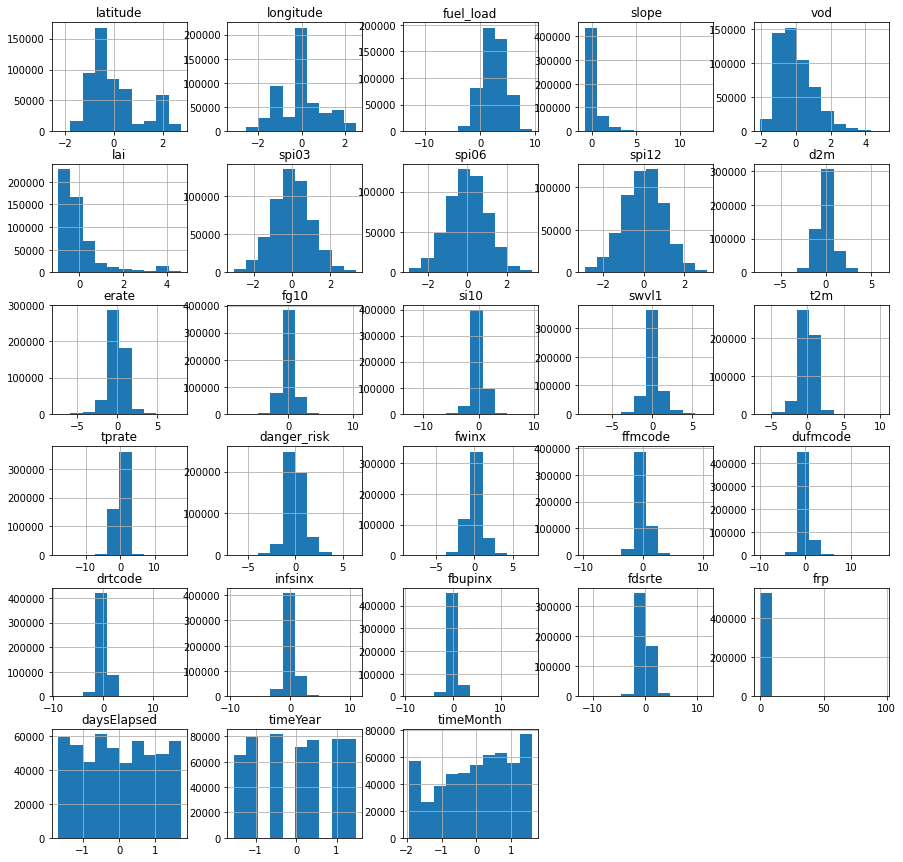

In [9]:
train_stand.hist(figsize = (15,15))

In [ ]:
# Convert data to H2O frame
train_data = h2o.H2OFrame(train_stand)
test_data = h2o.H2OFrame(test_stand)

In [39]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 24*60*60, seed = 1, stopping_metric = "mae", stopping_tolerance = 0.01,
                preprocessing = ["target_encoding"]) # TE is not necessary, I leave it here for future use
    
# Fit
aml.train(y = y, training_frame = train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [40]:
# Predict using test data
pre = np.exp(aml.predict(test_data).as_data_frame())

# Get performance - transformed
obs = np.exp(test_data[y].as_data_frame())
mean_absolute_error(obs, pre)

stackedensemble prediction progress: |████████████████████████████████████| 100%


44.370752953412925

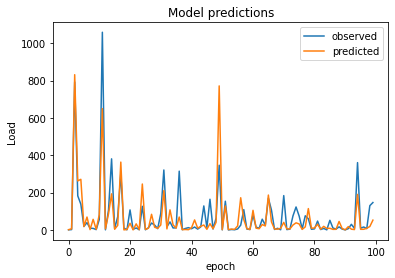

In [41]:
# Plot predictions
plt.plot(obs[0:100])
plt.plot(pre[0:100])
plt.title('Model predictions')
plt.ylabel('Load')
plt.xlabel('epoch')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

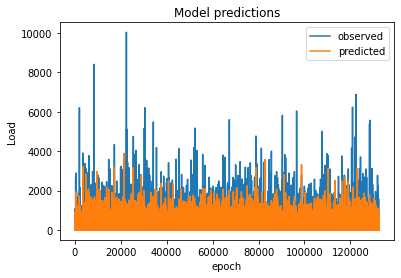

In [42]:
# Plot predictions
plt.plot(obs)
plt.plot(pre)
plt.title('Model predictions')
plt.ylabel('Load')
plt.xlabel('epoch')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

In [43]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()
#lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210517_125202,1.29169,1.13653,1.29169,0.887526,nan
StackedEnsemble_BestOfFamily_AutoML_20210517_125202,1.34066,1.15787,1.34066,0.907502,nan
GBM_grid__1_AutoML_20210517_125202_model_16,1.3838,1.17635,1.3838,0.92583,nan
GBM_grid__1_AutoML_20210517_125202_model_5,1.39175,1.17972,1.39175,0.925247,nan
GBM_grid__1_AutoML_20210517_125202_model_22,1.39566,1.18138,1.39566,0.927677,nan
GBM_grid__1_AutoML_20210517_125202_model_15,1.40014,1.18328,1.40014,0.930509,nan
GBM_grid__1_AutoML_20210517_125202_model_23,1.4014,1.18381,1.4014,0.927516,nan
XGBoost_grid__1_AutoML_20210517_125202_model_16,1.40215,1.18412,1.40215,0.92666,nan
XGBoost_grid__1_AutoML_20210517_125202_model_29,1.40338,1.18465,1.40338,0.926661,nan
GBM_grid__1_AutoML_20210517_125202_model_20,1.4236,1.19315,1.4236,0.939258,nan


In [46]:
# The leader model is stored here
# aml.leader

# Save the leader model
leadermodel_path = h2o.save_model(aml.leader, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(leadermodel_path)

/home/moc0/ai-vegetation-fuel/data/outputs/StackedEnsemble_AllModels_AutoML_20210517_125202


In [44]:
# Get second model
m2 = h2o.get_model(lb[1,"model_id"])

# Predict using test data
pre = np.exp(m2.predict(test_data).as_data_frame())

# Get performance - transformed
mean_absolute_error(obs, pre)

stackedensemble prediction progress: |████████████████████████████████████| 100%


46.17567333922904

In [45]:
# Get the third model
m3 = h2o.get_model(lb[2,"model_id"])

# Predict using test data
pre = np.exp(m3.predict(test_data).as_data_frame())

# Get performance - transformed
mean_absolute_error(obs, pre)

gbm prediction progress: |████████████████████████████████████████████████| 100%


48.16504358085174

In [47]:
# Save the third model
model3_path = h2o.save_model(m3, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(model3_path)

/home/moc0/ai-vegetation-fuel/data/outputs/GBM_grid__1_AutoML_20210517_125202_model_16


In [ ]:
# Load the model
# saved_model = h2o.load_model(model_path)

# Download the model built above to your local machine
# my_local_model = h2o.download_model(model, path="/Users/UserName/Desktop")

# Upload the model that you just downloded above to the H2O cluster
# uploaded_model = h2o.upload_model(my_local_model)

# Variable importance

See https://stackoverflow.com/questions/51640086/is-it-possible-to-get-a-feature-importance-plot-from-a-h2o-automl-model

In [50]:
m3.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,vod,2.543980e+06,1.000000,0.275994
1,frp,1.976110e+06,0.776779,0.214387
2,longitude,5.836963e+05,0.229442,0.063325
3,latitude,3.030553e+05,0.119126,0.032878
4,GFEDregions,2.857135e+05,0.112310,0.030997
5,timeMonth,2.751977e+05,0.108176,0.029856
6,climatic_region,2.522017e+05,0.099137,0.027361
7,biome,2.503055e+05,0.098391,0.027155
8,lai,2.079407e+05,0.081738,0.022559
9,daysElapsed,1.932813e+05,0.075976,0.020969


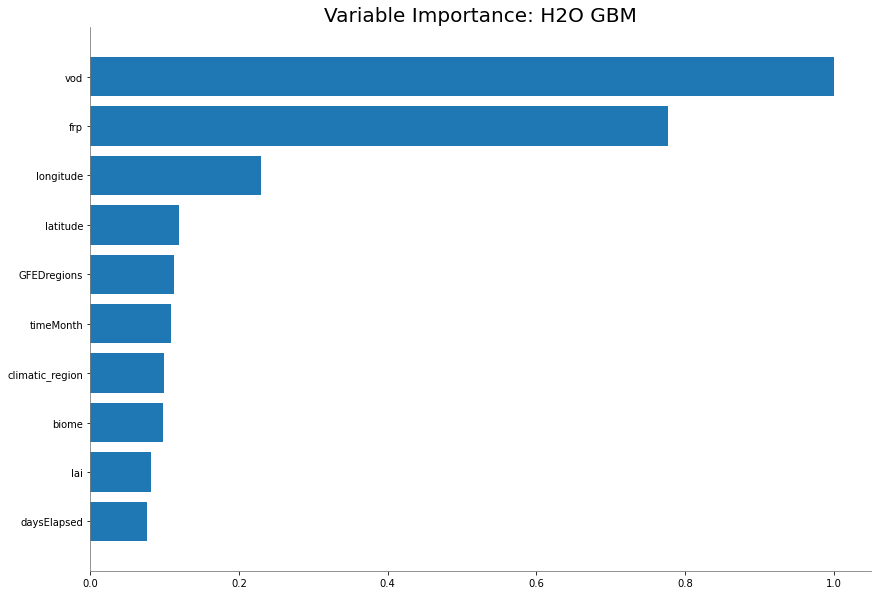

In [51]:
m3.varimp_plot()

The following functions take a list of models (including an AutoML object or leaderboard slice) as input:

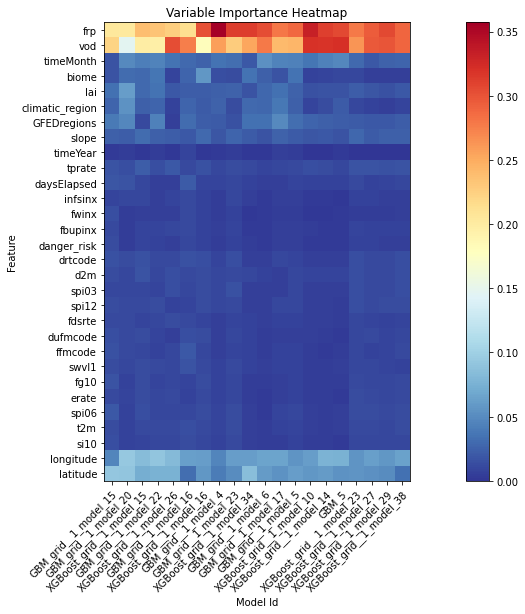

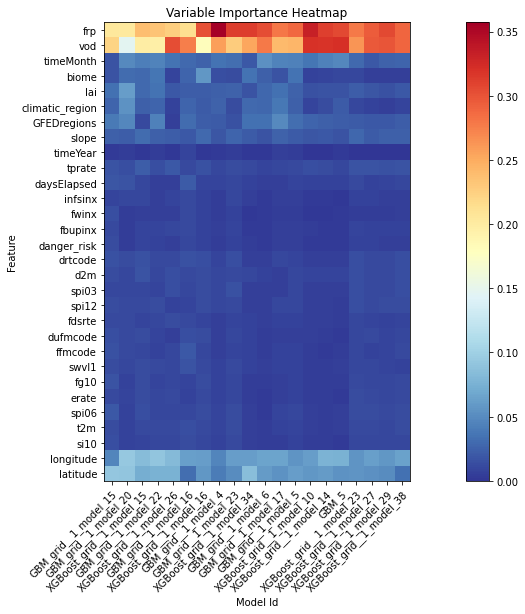

In [52]:
# These are methods for an AutoML object
# Use h2o.method_name(model_list, test) for a list of models
aml.varimp_heatmap()
#.model_correlation_heatmap()
#.pd_multi_plot()

These functions take a single H2O model as input:

In [ ]:
# Methods for an H2O model
.residual_analysis_plot()
.varimp_plot()
.shap_explain_row_plot()
.shap_summary_plot()
.pd_plot()
.ice_plot()

# Explainability

See https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#explainability and https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210517_125202,1.29169,1.13653,1.29169,0.887526,nan,7107,0.017734,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210517_125202,1.34066,1.15787,1.34066,0.907502,nan,385,0.003819,StackedEnsemble
GBM_grid__1_AutoML_20210517_125202_model_16,1.3838,1.17635,1.3838,0.92583,nan,13595,0.002589,GBM
GBM_grid__1_AutoML_20210517_125202_model_5,1.39175,1.17972,1.39175,0.925247,nan,16896,0.003109,GBM
GBM_grid__1_AutoML_20210517_125202_model_22,1.39566,1.18138,1.39566,0.927677,nan,22569,0.002133,GBM
GBM_grid__1_AutoML_20210517_125202_model_15,1.40014,1.18328,1.40014,0.930509,nan,20147,0.002458,GBM
GBM_grid__1_AutoML_20210517_125202_model_23,1.4014,1.18381,1.4014,0.927516,nan,24707,0.003045,GBM
XGBoost_grid__1_AutoML_20210517_125202_model_16,1.40215,1.18412,1.40215,0.92666,nan,46090,0.001618,XGBoost
XGBoost_grid__1_AutoML_20210517_125202_model_29,1.40338,1.18465,1.40338,0.926661,nan,49387,0.001056,XGBoost
GBM_grid__1_AutoML_20210517_125202_model_20,1.4236,1.19315,1.4236,0.939258,nan,8894,0.002668,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

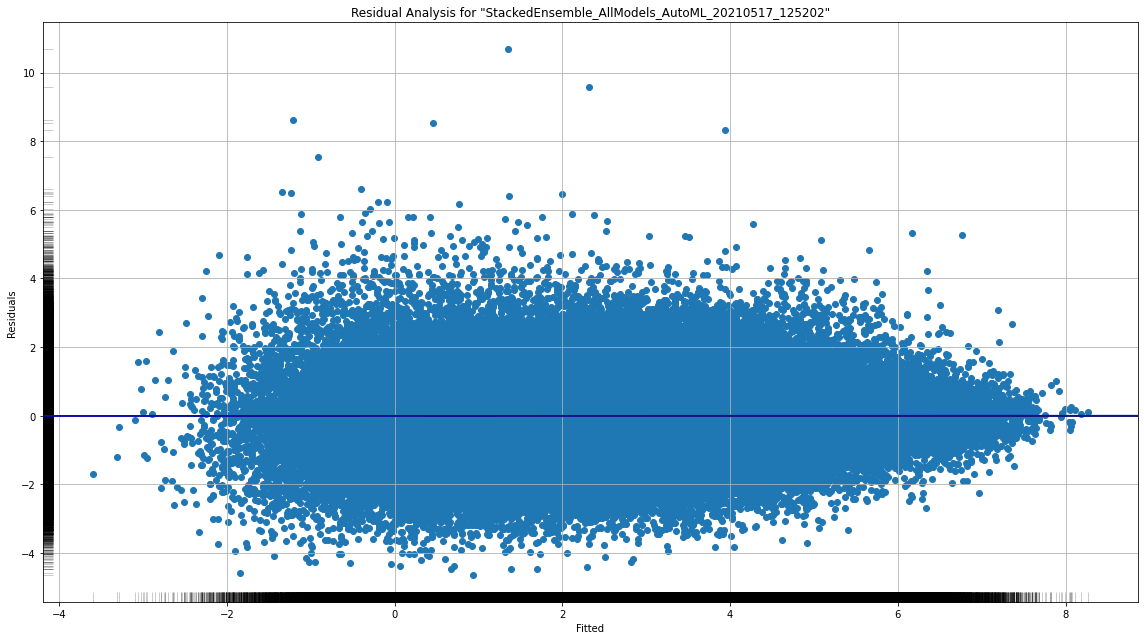

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

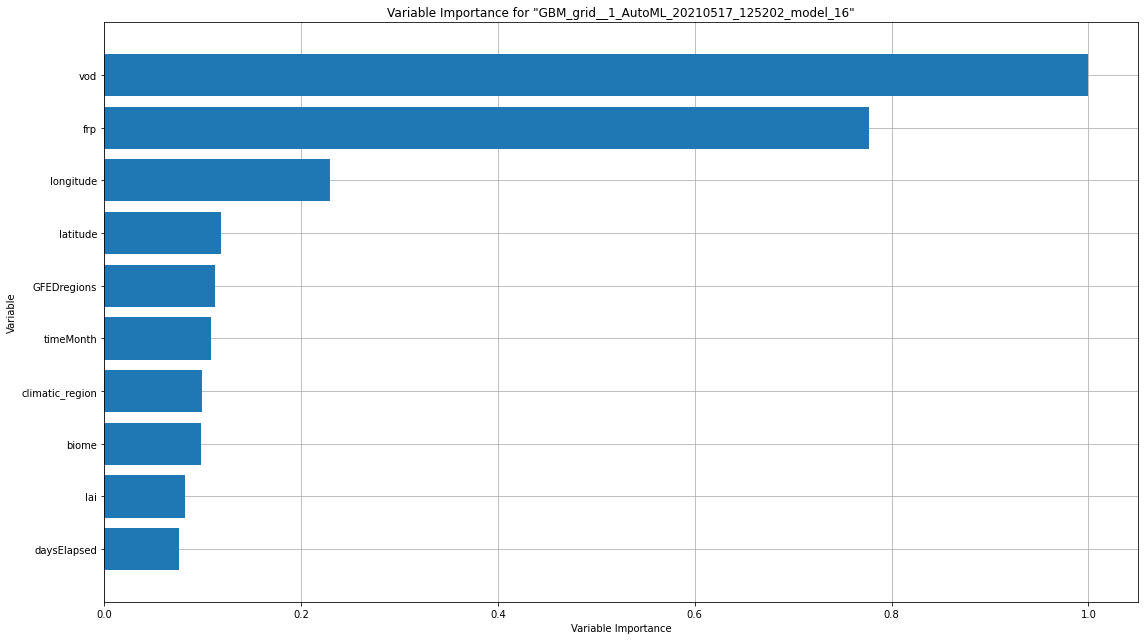

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

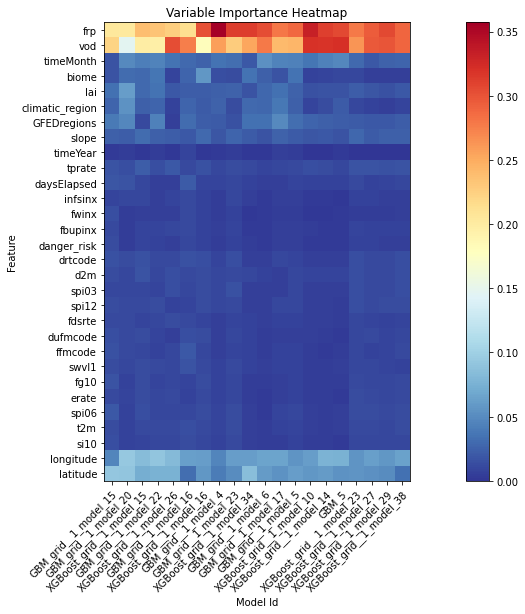

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

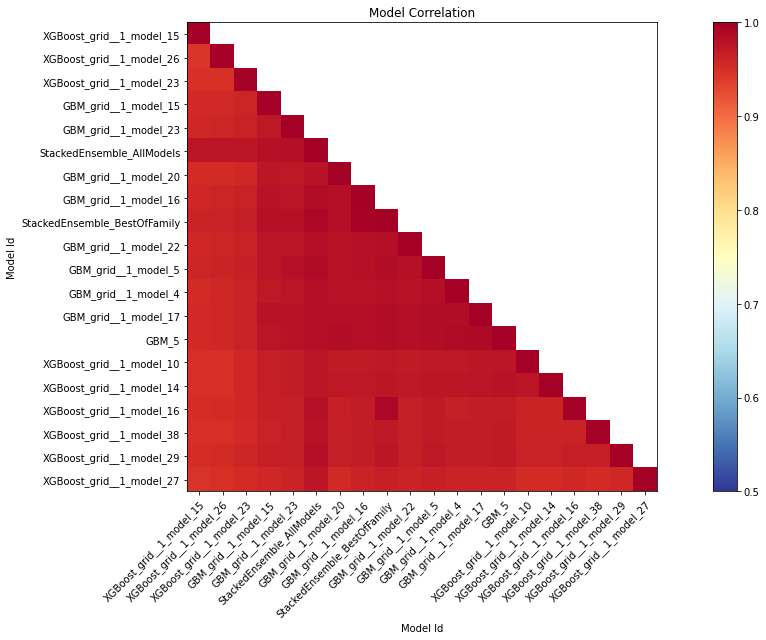

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

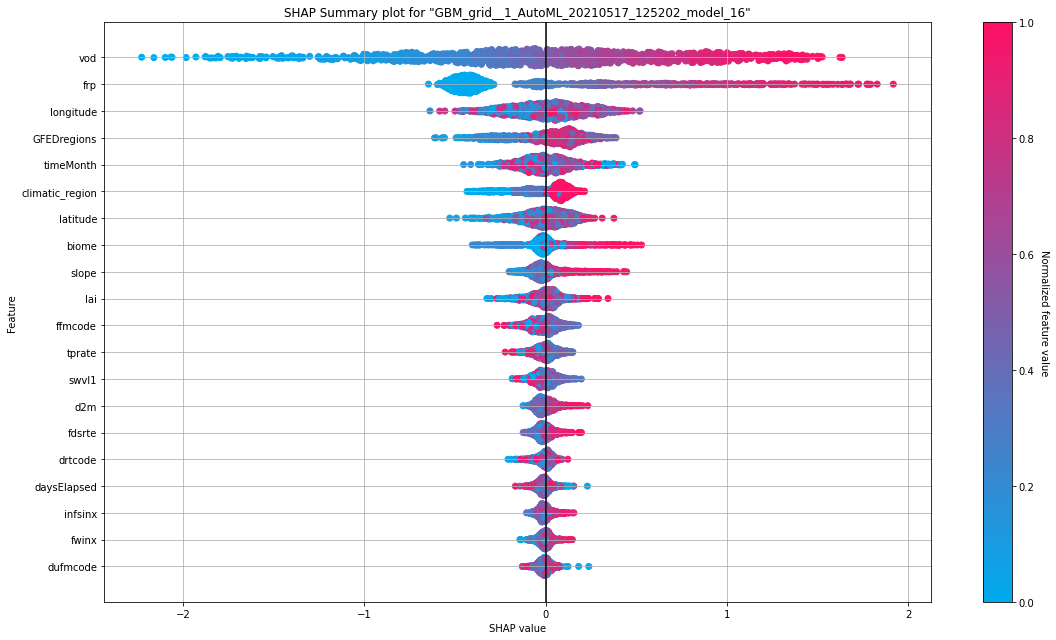

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

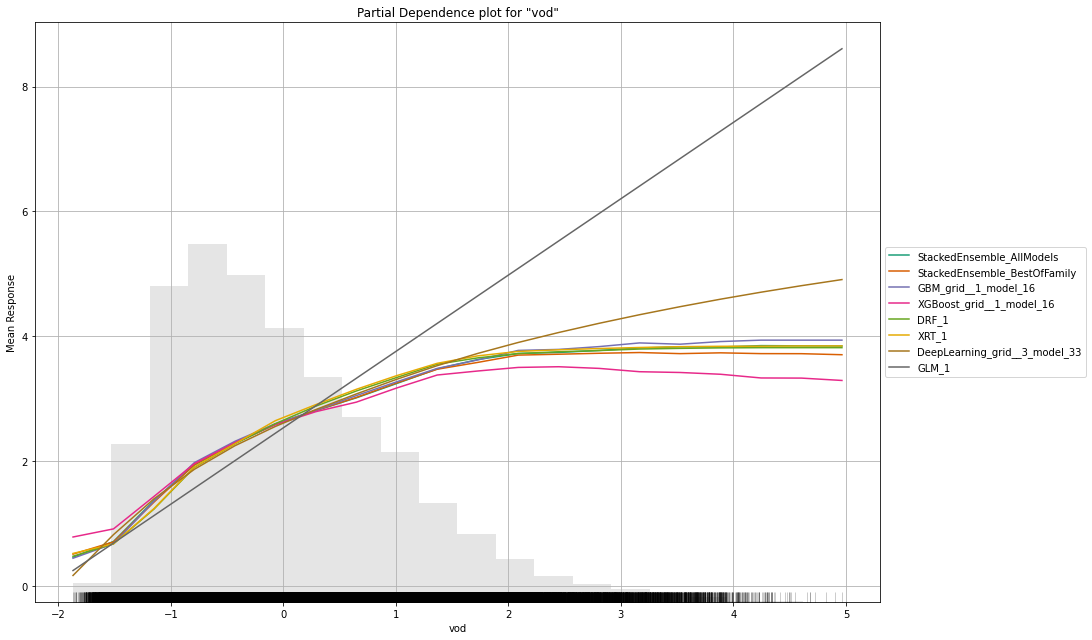

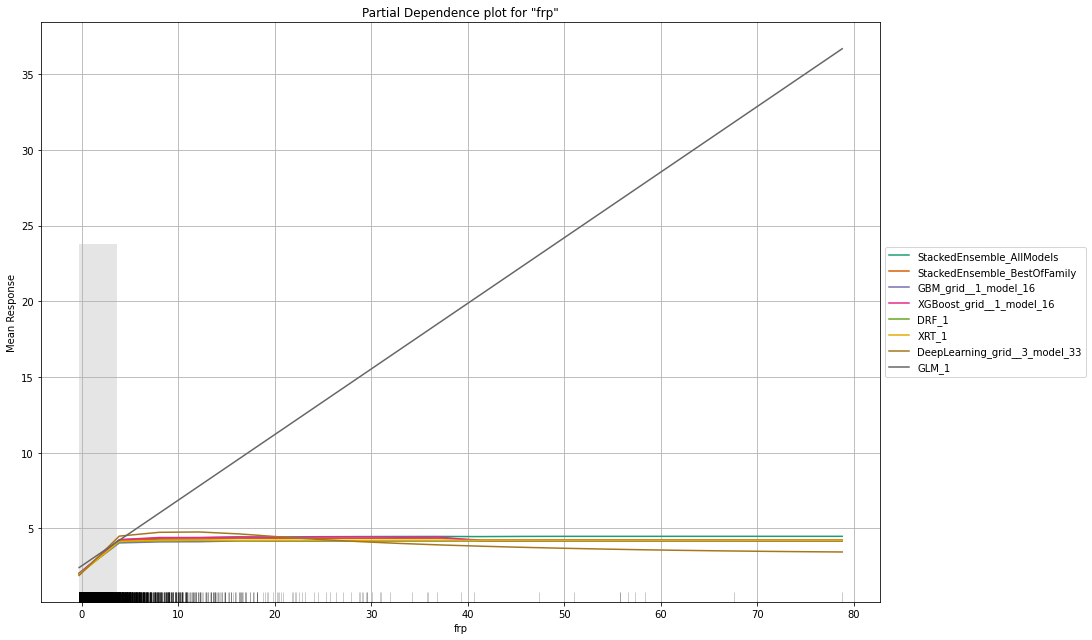

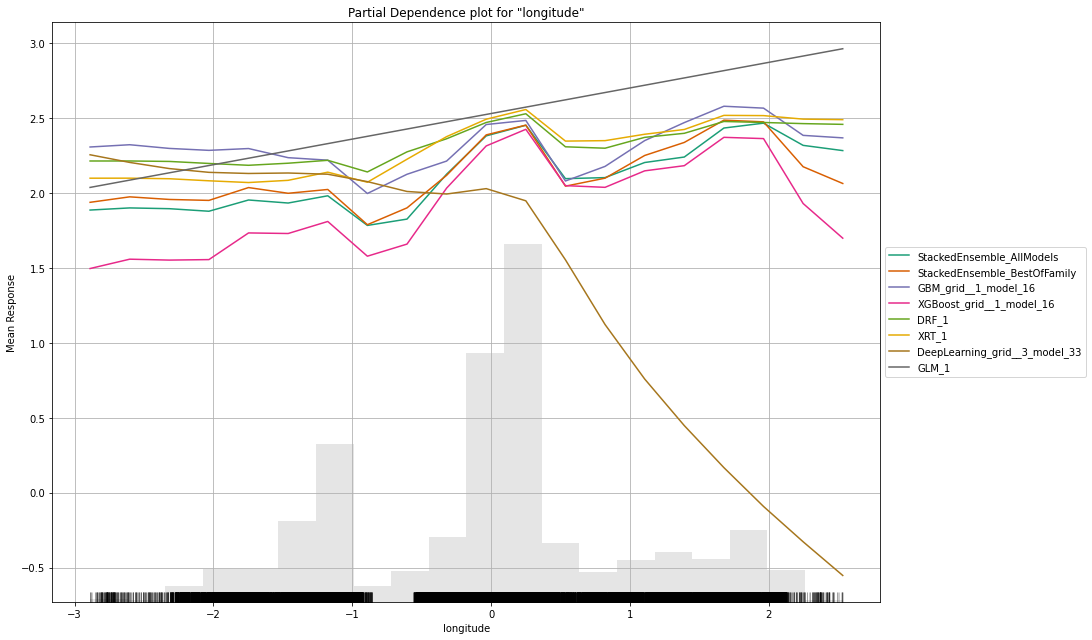

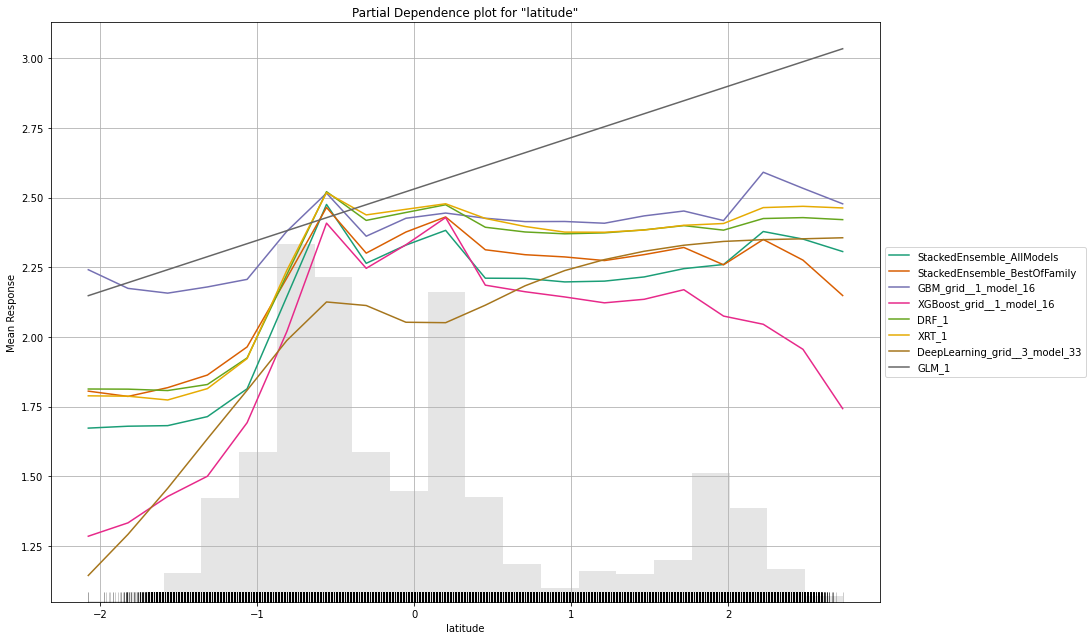

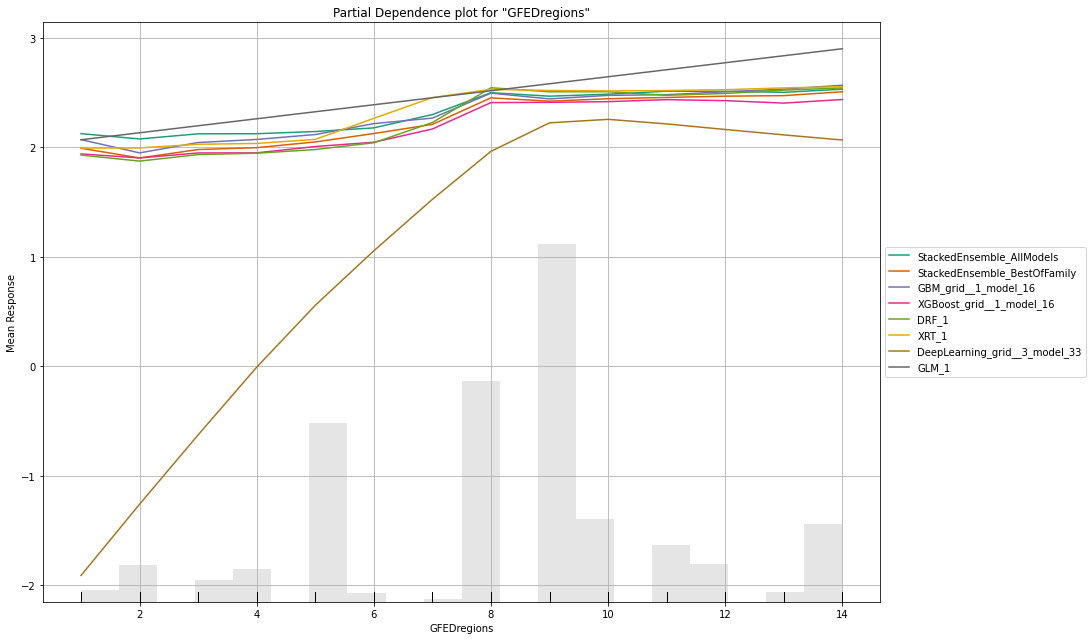

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

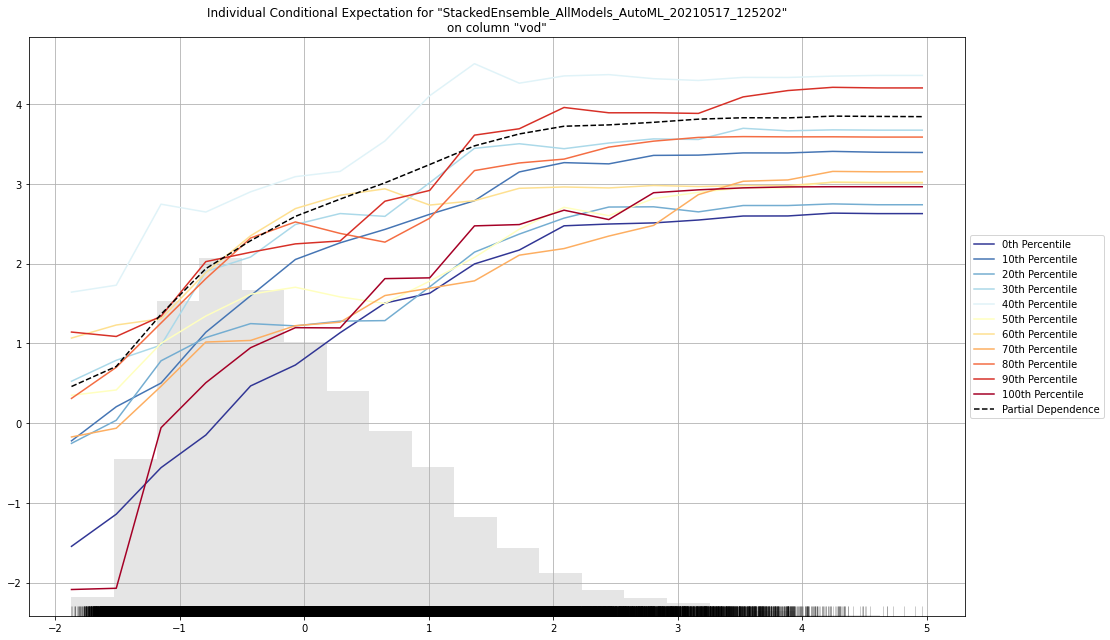

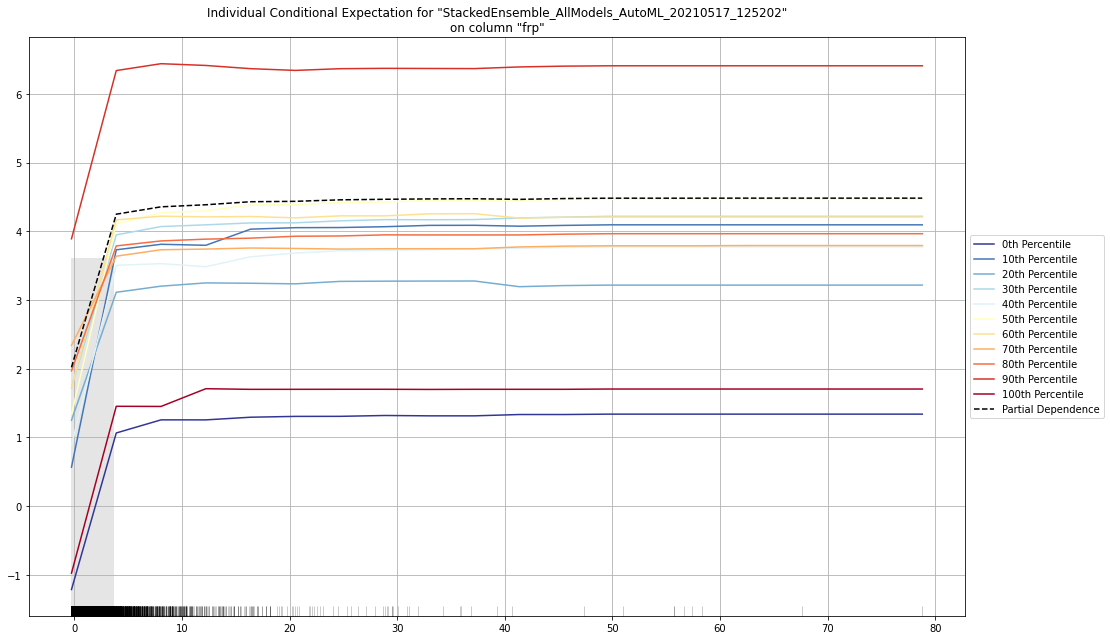

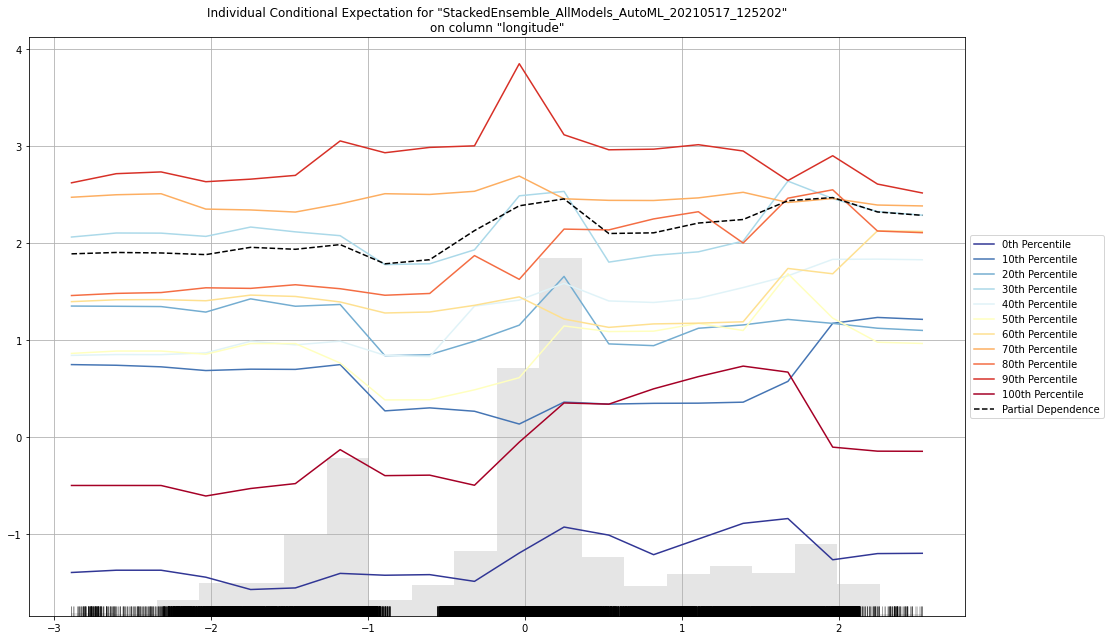

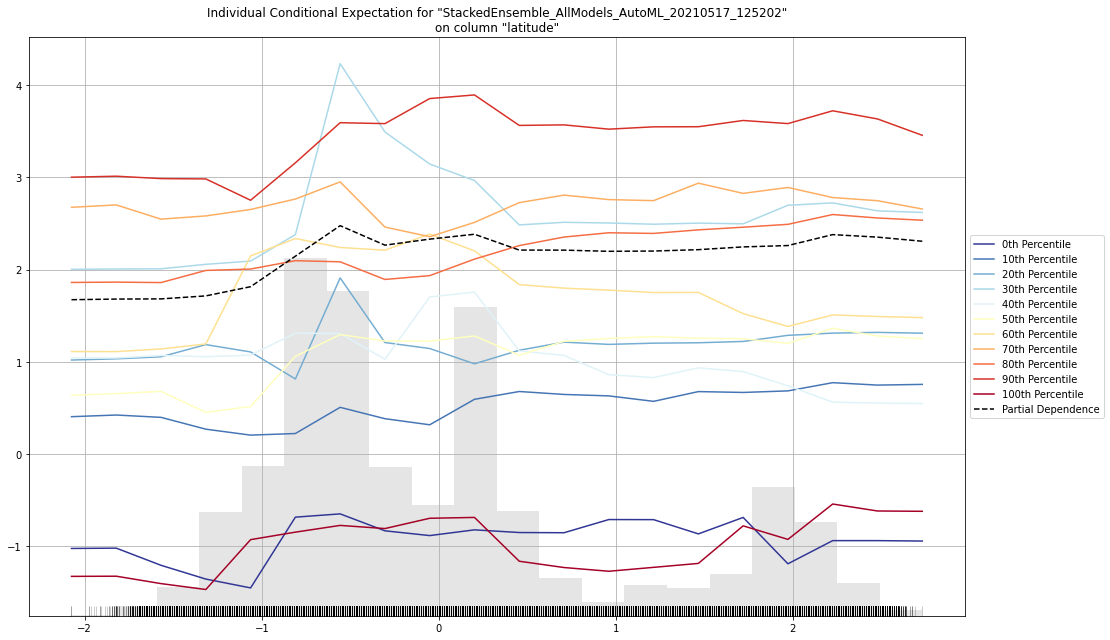

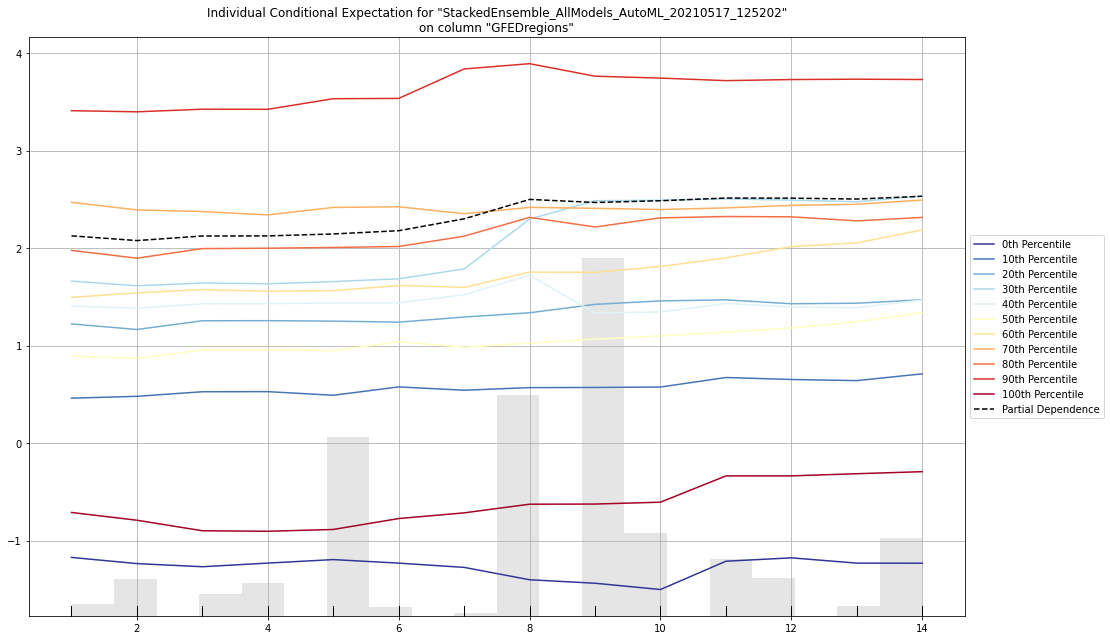

In [54]:
# Explain an AutoML object
exa = aml.explain(test_data)

# Resources

H2O AutoML:
- https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e#:~:text=H2O%20AutoML%20functionalities&text=Necessary%20data%20pre%2Dprocessing%20capabilities,are%20tuned%20using%20cross%2Dvalidation.

Data transformations:
- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- https://www.kaggle.com/product-feedback/164183
- https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712
- https://machinelearningmastery.com/power-transforms-with-scikit-learn/
- https://robjhyndman.com/hyndsight/transformations/
- https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros